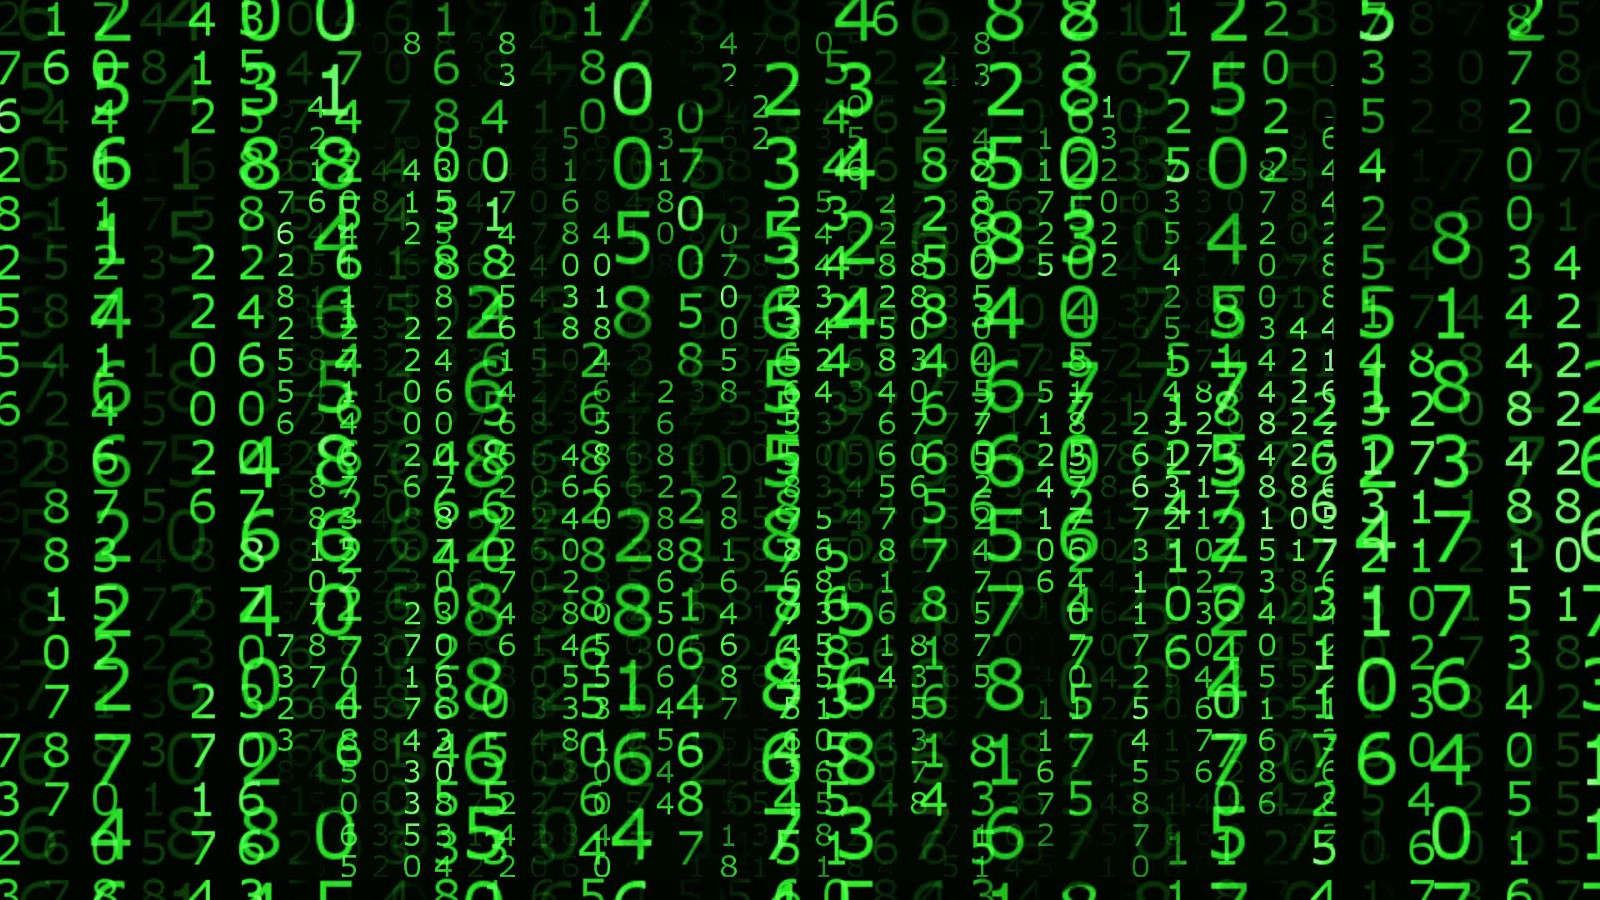

# We will be using a SVM model for this digit recognition analysis.

#### Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

#### We need to convert these images into actual pixels format so that they can be fed into the model. We will leverage python's PIL (Python Image Library) package to help convert these images.

#### The converted image dataset would consist of pair, “handwritten digit image” and “label”. Digit ranges from 0 to 9, meaning 10 patterns in total.

    1. handwritten digit image: This is gray scale image with size 28 x 28 pixel.
    2. label : This is actual digit number this handwritten digit image represents. It is either  0 to 9.

In [136]:
# Import all the necessary library and pacgakes

import os,png,array
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import gc
import warnings

from PIL import Image
from skimage import feature

import cv2
import mahotas
import _pickle as cPickle

In [137]:
# Initialize notebook parameters

# To display all the columns
pd.options.display.max_columns = None

# To display all the rows
pd.options.display.max_rows = None

# To map Empty Strings or numpy.inf as Na Values
pd.options.mode.use_inf_as_na = True

# Set Precision to 8 for better readability
pd.set_option('precision', 8)
pd.options.display.float_format = '{:.4f}'.format

pd.options.display.expand_frame_repr =  False

%matplotlib inline

# Set Style
sns.set(style = "whitegrid")

# Ignore Warnings
warnings.filterwarnings('ignore')

In [134]:
# Variable declaration
HOG_feature_data = []
test_data = False

# Part 1 - Data Import

#### The below script will help converting the ".png" images into pixel format and write them into a csv file. 
#### The generated csv file will be fed into for our model building.

#### The script used methods from the image module in python's PIL package. We will be using the below methods in the script.

#### PIL.Image.open(fp, mode='r') : 
    Opens and identifies the given image file.
    This is a lazy operation; this function identifies the file, but the file remains open and the actual image data is 
    not read from the file until you try to process the data (or call the load() method).
    
#### Image.load() : 
    Allocates storage for the image and loads the pixel data.

#### We will repeat the above 2 methods for the entire set of 49000 images and append the pixel data for each image to an array. This  rawData will then be concateneted with the respective image label provided in the "train.csv" file. The resultant dataset will be written to a csv file which will be out input/train data for the model.

#### ***Note that the script will take time to run.


In [4]:
# import time

# os.chdir('C:/Hackathons/Digits_Identification-AnalyticsVidya/Train_UQcUa52/Images/train')

# Creating a list of columns to represent the pixel format for a particular image.

# columnNames = list()
# for i in range(784):
#     pixel = 'pixel'
#     pixel += str(i)
#     columnNames.append(pixel)

# pixel_data = pd.DataFrame(columns = columnNames)
# start_time = time.time()
# for i in range(1,49000):
#     img_name = str(i)+'.png'
#     img = Image.open(img_name)
#     rawData = img.load()
#     data = []
#     for y in range(28):
#         for x in range(28):
#             data.append(rawData[x,y][0])
#     k = 0
#     pixel_data.loc[i] = [data[k] for k in range(784)]

# The below 6 lines of code does not need to be executed for test image set as we do not want the label column.
# **************************************************************************************************************
# label_data = pd.read_csv("train.csv")
# train_labels = label_data['label']
# pixel_data = pd.concat([label_data, pixel_data],axis = 1)
# pixel_data = pixel_data.drop('filename',1)
# pixel_data = pixel_data.dropna()
# **************************************************************************************************************

# Convert the pixel dataset into a csv file.
# pixel_data.to_csv("image_pixel_data.csv",index = False)

# Change the directory to the original directory. This could change depending on the directory level.
# os.chdir('../../../')
# print("Conversion completed in  - ", time.time()-start_time)

## An image in pixel format looks as below -

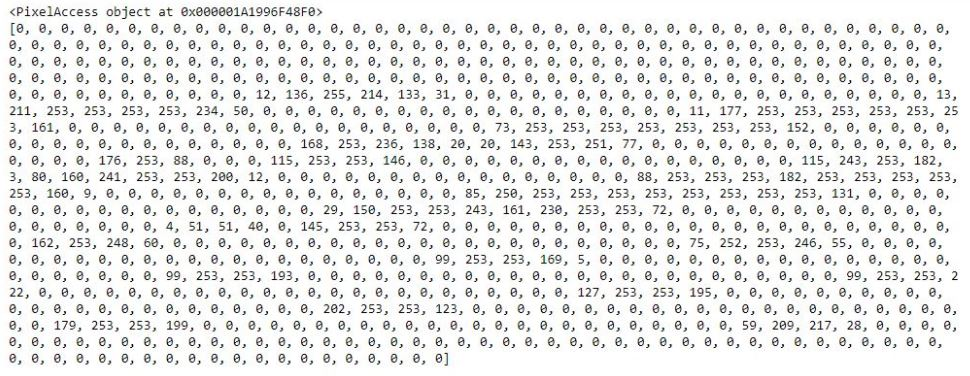


#### Our final data set will consist of such pixel format entries spread across 784 columns for all the images.

# Part 2 - Image Preprocessing

In [131]:
def getdigits(dfPath):
    
    if test_data == True:
        # build the dataset. We do not have the label column in case of test data. 
        # Hence we would not get the target/labels and return 0 for the same.
        data = np.genfromtxt(dfPath, delimiter = ",", dtype = "uint8")
        data = data[:, 0:].reshape(data.shape[0], 28, 28)
        # return a tuple of the data and targets
        return (data, 0)
    else:
        # build the dataset and then split it into data and labels (target)
        data = np.genfromtxt(dfPath, delimiter = ",", dtype = "uint8")
        target = data[:, 0]
        data = data[:, 1:].reshape(data.shape[0], 28, 28)
        # return a tuple of the data and targets
        return (data, target)

In [81]:
# This method has been included as part of getdigits method.

# def get_test_digits(dfPath):
#     # build the dataset 
#     data = np.genfromtxt(dfPath, delimiter = ",", dtype = "uint8")
#     data = data[:, 0:].reshape(data.shape[0], 28, 28)

#     # return a tuple of the data and targets
#     return data

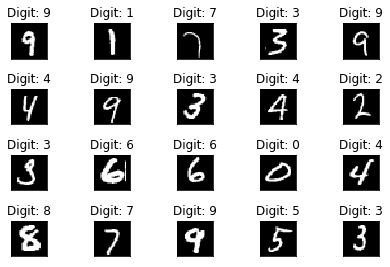

In [7]:
test_data = False
(imgdata,label) = getdigits('train_img_label_vectorized.csv')

%matplotlib inline


for i in range(1, 21):
  plt.subplot(4,5,i)
  plt.tight_layout()
  plt.imshow(imgdata[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

#### This is how our images looked like in the image collection. So the conversion is correct. Now lets do some more analysis on the pixel format for an image.

In [8]:
digits_df = pd.read_csv('train_img_label_vectorized.csv')
digits_df.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      9       0       0       0       0       0       0       0       0   
1      1       0       0       0       0       0       0       0       0   
2      7       0       0       0       0       0       0       0       0   
3      3       0       0       0       0       0       0       0       0   
4      9       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         0  
1         0         0         0         0         0  
2         0         0         0         0         0  
3         0         0         0         0         0  
4         0         0         0         0         0  

[5 rows x 785 columns]

#### Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [9]:
digit_nine = digits_df.iloc[0, 1:]
digit_nine.shape

(784,)

#### As we have the pixels represented in the column format, inorder to visualize a particular image, we need to represent these pixels in a matrix form. All our images are of size (28 x 28). So the entire 784 columns need to be reshaped to a (28 x 28) matrix form.

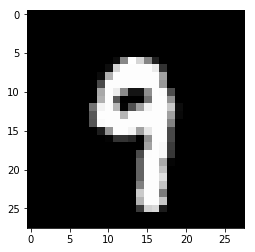

In [10]:
digit_nine = digit_nine.values.reshape(28, 28)
plt.imshow(digit_nine, cmap='gray')

#### Lets also visualize the pixel (28 x 28) array.

In [11]:
print(digit_nine[5:-5, 5:-5])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  12 136 255 214 133  31   0   0   0   0   0   0]
 [  0   0   0   0   0  13 211 253 253 253 253 234  50   0   0   0   0   0]
 [  0   0   0   0  11 177 253 253 253 253 253 253 161   0   0   0   0   0]
 [  0   0   0   0  73 253 253 253 253 253 253 253 152   0   0   0   0   0]
 [  0   0   0   0 168 253 236 138  20  20 143 253 251  77   0   0   0   0]
 [  0   0   0   0 176 253  88   0   0   0 115 253 253 146   0   0   0   0]
 [  0   0   0 115 243 253 182   3  80 160 241 253 253 200  12   0   0   0]
 [  0   0   0  88 253 253 253 182 253 253 253 253 253 160   9   0   0   0]
 [  0   0   0  85 250 253 253 253 253 253 253 253 253 131   0   0   0   0]
 [  0   0   0   0  29 150 253 253 243 161 230 253 253  72   0   0   0   0]
 [  0   0   0   0   0   4  51  51  40   0 145 253 253  72   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 162 253 248  60   0   0   0   0]
 [  0   0   0   0   0   0

#### Before starting to implement a classifier we need to do some pre-processing with the images so that we can make a efficient model. We will follow the below 2 procedures as part of image pre-processing. 

1. **Deskew Image** 

    - The process of straightening an image that has been scanned or photographed crookedly — that is an image that is 
     slanting too far in one direction, or one that is misaligned. 

    - Aligning digits before building a classifier similarly produces superior results. In the case of faces, aligment is 
    rather obvious — you can apply a similarity transformation to an image of a face to align the two corners of the eyes
    to the two corners of a reference face.

    - In the case of handwritten digits, we do not have obvious features like the corners of the eyes we can use for alignment. However, an obvious variation in writing among people is the slant of their writing. Some writers have a right or forward slant where the digits are slanted forward, some have a backward or left slant, and some have no slant at all. We can help the algorithm quite a bit by fixing this vertical slant so it does not have to learn this variation of the digits.

    
2. **Re-Center Image** - Cemtre aling the image (or the image object) 


**Ref** - 

1. [handwritten-digits-classification-an-opencv-c-python-tutorial](https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/)
    
2. [image-processing-for-text-recognition](http://blog.mathocr.com/2017/06/25/image-processing-for-text-recognition.html)


In [12]:
def deskewImage(image, width):
    # grab the width and height of the image and compute
    # moments for the image
    (h, w) = image.shape[:2]
    moments = cv2.moments(image)
    
    # deskew the image by applying an affine transformation
    skew = moments["mu11"] / moments["mu02"]
    M = np.float32([
        [1, skew, -0.5 * w * skew],
        [0, 1, 0]])
    image = cv2.warpAffine(image, M, (w, h),
        flags = cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

    # resize the image to have a constant width
    image = cv2.resize(image, (28,28))
    
    # return the deskewed image
    return image

#### CV2/OpenCV -
    OpenCV (Open Source Computer Vision Library) is an open source computer vision and machine learning software library. 
    OpenCV was built to provide a common infrastructure for computer vision applications and to accelerate the use of 
    machine perception in the commercial products.
    
#### Image Moments - 
    Image moment is a certain particular weighted average (moment) of the image pixels' intensities.  
    Image moments are useful to describe objects.  Simple properties of the image which are found via 
    image moments include area (or total intensity), its centroid, and information about its orientation.
    
#### Affine Transformations - 

    Affine transformation is a linear mapping method that preserves points, straight lines, and planes. Sets of parallel
    lines remain parallel after an affine transformation. The affine transformation technique is typically used to 
    correct for geometric distortions or deformations that occur with non-ideal camera angles.
    
**More information on OpenCV methods can be found at** - https://www.analyticsvidhya.com/blog/2019/03/opencv-functions-computer-vision-python/
    
#### Lets have a look at how the above function de-skews an image.

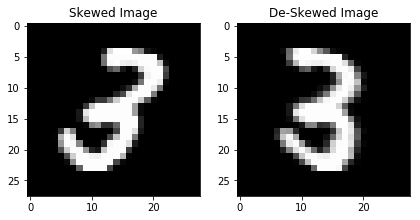

In [13]:
deSkewedImage = deskewImage(imgdata[8],28)

plt.subplot(1,2,1)
plt.tight_layout()
plt.imshow(imgdata[8], cmap='gray', interpolation='none')
plt.title("Skewed Image")

plt.subplot(1,2,2)
plt.tight_layout()
plt.imshow(deSkewedImage, cmap='gray', interpolation='none')
plt.title("De-Skewed Image")

plt.show()

#### Now lets try to re-centre an image.

#### Parameters user -

- INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results.

- **Mahotas** - A computer vision and image processing library for Python.

- **Affine transformation** - A linear mapping method that preserves points, straight lines, and planes.

In [14]:
def centre_align_image(image, size):
    # grab the extent width and height
    (eW, eH) = size
    
    #Image Shape is
    (h, w) = image.shape[:2]
    
    #New dimension according to image aspect ratio
    dim = None
    
    # handle when the width is greater than the height
    if image.shape[1] > image.shape[0]:
        #image = resize(image, width = eW)
        r = eW / float(w)
        dim = (eW, int(h * r))
        image = cv2.resize(image,dim,cv2.INTER_AREA)

    # otherwise, the height is greater than the width
    else:
        #image = resize(image, height = eH)
        r = eH / float(h)
        dim = (int(w * r), eH)
        image = cv2.resize(image,dim,cv2.INTER_AREA)

    # allocate memory for the extent of the image and grab it
    extent = np.zeros((eH, eW), dtype = "uint8")
    offsetX = (eW - image.shape[1]) / 2
    offsetY = (eH - image.shape[0]) / 2
    offsetX = int(offsetX)
    offsetY = int(offsetY)
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX + image.shape[1]] = image

    # compute the center of mass of the image and then
    # move the center of mass to the center of the image
    (cY, cX) = np.round(mahotas.center_of_mass(extent)).astype("int32")
    (dX, dY) = ((size[0] / 2) - cX, (size[1] / 2) - cY)
    M = np.float32([[1, 0, dX], [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)

    # return the extent of the image
    return extent

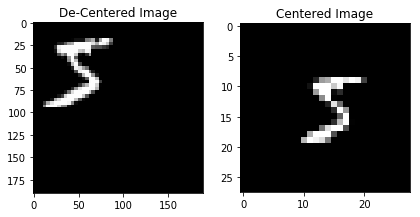

In [15]:
# An example transformation on a de-centered image.

img = cv2.imread('Decenter.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
aligned_image = centre_align_image(img,(28,28))

plt.subplot(1,2,1)
plt.tight_layout()
plt.imshow(img, cmap='gray', interpolation='none')
plt.title("De-Centered Image")

plt.subplot(1,2,2)
plt.tight_layout()
plt.imshow(aligned_image, cmap='gray', interpolation='none')
plt.title("Centered Image")

plt.show()

# Histogram of Oriented Gradients (HOG) features -

1. Histogram
2. Oriented
3. Gradients

**Histogram** is nothing but a frequncy map which shows how many times a random variable appears in the context.
**Orientation** is directly associated with angles.
**Gradients** signifies transitions of a random variable.

**HOG shows us a frequency map of edges (Gradients) in different orientations of an Image.

#### Lets define a method for extracting the HOG features. 

In [16]:
def extract_HOG_features(image):
    hist = feature.hog(image, orientations = 9,
        pixels_per_cell = (8, 8),
        cells_per_block = (3, 3)
        )
    return hist

#### Lets get the HOG features for a particular image

In [17]:
hist = extract_HOG_features(imgdata[0])

print(np.shape(hist))

(81,)


#### So a total of 81 features were extracted from the image. It is roughly 9 histograms from an image with 9 bins

#### Lets now apply the above transformation & feature extraction methods to our entire data set

In [90]:
# This method transforms an image to a proper format so as to increase the performance of the classifier.
def processImages(filePath):
    image_size = 28
    
    (digits, target) = getdigits(filePath)

    # loop over the images
    for image in digits:
        # deskew the image, center it
        image = deskewImage(image, image_size)
        image = centre_align_image(image, (image_size, image_size))
    
        # describe the image and update the data matrix
        hist = extract_HOG_features(image)
        HOG_feature_data.append(hist)

In [ ]:
#call the above function tp apply the transformations.
test_data = False
processImages('train_img_label_vectorized.csv')

In [32]:
print("Total images processed - ", len(HOG_feature_data))
print("HOG features extracted per image - ", len(HOG_feature_data[0]))

Total images processed -  49000
HOG features extracted per image -  81


#### Now with this we are done with the image or data preparation phase.

# Part 3 - Exploratory Data Analysis

In [76]:
# Let's check the total number of observations present for each digit.
# Our label field represents numbers (int) from 1 to 9. But the label column is actually a categorical
# column here. Let's convert 'label' field as categorical for a smoother and correct analysis.

digits_df.label = digits_df.label.astype('category')

digits_df.label.value_counts()

1    5514
7    5105
3    4999
2    4893
9    4871
0    4832
6    4813
8    4777
4    4776
5    4419
Name: label, dtype: int64

In [78]:
# Summarise count in terms of percentage 
(round(digits_df.label.value_counts()/len(digits_df.index), 4))*100

1    11.25
7    10.42
3    10.20
2     9.99
9     9.94
0     9.86
6     9.82
8     9.75
4     9.75
5     9.02
Name: label, dtype: float64

As we see ach digit has around 9%-11% share in the dataset and we can say that the **dataset is balanced**. 
This is an important factor in considering the choices of models to be used, especially SVM, since **SVMs usually do not perform well on imbalanced data**.

In [39]:
# average values/distributions of features
description = digits_df.describe()
description

label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  48999.000000  48999.0  48999.0  48999.0  48999.0  48999.0  48999.0   
mean       4.452417      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.890235      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8    ...         pixel774      pixel775  \
count  48999.0  48999.0  48999.0    ...     48999.000000  48999.000000   
mean       0.0      0.0      0.0    ...         0.191188      0.092043   
std        0.0      0.0      0.0    ...         5.993801      4.010469   
min        0.0      0.0      0.0    ...         0.000000      0.000000   
25%        0.0      0.0      0.0    ...         0.000000      0.000000   
50%        0.0      0.0      0.0    ...         0.000000      0.000000   
75%        0.0      0.0      0.0    ...         0.000000      0.000000   
max        0.0      0.0      0.0    ...       255.000000    254.000000   

           pixel776      pixel777      pixel778      pixel779  pixel780  \
count  48999.000000  48999.000000  48999.000000  48999.000000   48999.0   
mean       0.048634      0.019674      0.008857      0.001265       0.0   
std        2.939792      1.802626      1.246982      0.280090       0.0   
min        0.000000      0.000000      0.000000      0.000000       0.0   
25%        0.000000      0.000000      0.000000      0.000000       0.0   
50%        0.000000      0.000000      0.000000      0.000000       0.0   
75%        0.000000      0.000000      0.000000      0.000000       0.0   
max      253.000000    253.000000    243.000000     62.000000       0.0   

       pixel781  pixel782  pixel783  
count   48999.0   48999.0   48999.0  
mean        0.0       0.0       0.0  
std         0.0       0.0       0.0  
min         0.0       0.0       0.0  
25%         0.0       0.0       0.0  
50%         0.0       0.0       0.0  
75%         0.0       0.0       0.0  
max         0.0       0.0       0.0  

[8 rows x 785 columns]

#### You can see that the max value of the mean and maximum values of some features (pixels) is 139, 255 etc., while most features lie in much lower ranges.

#### Thus, rescale of the features would be required for building a better model.

# Part 4 - Data Preparation for Model Building

In [51]:
# Creating training and test sets
# Splitting the data into train and test
X = digits_df.iloc[:, 1:]
y = digits_df.iloc[:, 0]

# Rescaling the features
X = scale(X)

# train test split with train_size=10% and test size=90%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  import sys


(39199, 784)
(9800, 784)
(39199,)
(9800,)


# Part 5 - Model Building

## Linear SVM

In [52]:
linear_SVM = svm.SVC(kernel='linear')

# fit
linear_SVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [54]:
# predict
predictions = linear_SVM.predict(X_test)
predictions[:10]

array([4, 0, 0, 8, 1, 1, 2, 0, 2, 6], dtype=int64)

In [55]:
confusion_matrix = metrics.confusion_matrix(y_true = y_test, y_pred = predictions)
confusion_matrix

array([[ 936,    0,    8,    0,    4,   13,   11,    0,    3,    2],
       [   1, 1116,    6,    3,    1,    2,    1,    2,    5,    2],
       [   9,   15,  883,   22,   11,    4,    6,    8,   12,    3],
       [   2,    7,   29,  875,    1,   29,    0,    6,   17,    7],
       [   1,    4,   13,    1,  875,    3,    2,    8,    1,   33],
       [  12,    5,   13,   45,    1,  728,   13,    3,   12,   14],
       [   7,    3,   15,    2,    7,   13,  932,    0,    7,    0],
       [   2,    8,   13,    5,   16,    3,    0,  916,    1,   37],
       [  14,   23,   27,   45,    2,   29,    9,    3,  832,   13],
       [   5,    7,    4,   10,   37,   10,    0,   48,    1,  845]],
      dtype=int64)

In [56]:
metrics.accuracy_score(y_true=y_test, y_pred=predictions)

0.9120408163265306

In [57]:
# class-wise accuracy
class_wise = metrics.classification_report(y_true=y_test, y_pred=predictions)
print(class_wise)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       977
           1       0.94      0.98      0.96      1139
           2       0.87      0.91      0.89       973
           3       0.87      0.90      0.88       973
           4       0.92      0.93      0.92       941
           5       0.87      0.86      0.87       846
           6       0.96      0.95      0.95       986
           7       0.92      0.92      0.92      1001
           8       0.93      0.83      0.88       997
           9       0.88      0.87      0.88       967

   micro avg       0.91      0.91      0.91      9800
   macro avg       0.91      0.91      0.91      9800
weighted avg       0.91      0.91      0.91      9800



In [58]:
# run gc.collect() (garbage collect) to free up memory
# else, since the dataset is large and SVM is computationally heavy,
# it'll throw a memory error while training
gc.collect()

1108

## Non-Linear SVM

## RBF Kernel

In [59]:
# rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [61]:
# predict
predictions = svm_rbf.predict(X_test)
predictions[:10]

array([4, 0, 0, 8, 1, 1, 6, 0, 2, 6], dtype=int64)

In [62]:
# accuracy 
print(metrics.accuracy_score(y_true=y_test, y_pred=predictions))

0.9593877551020408


The accuracy achieved with a non-linear kernel is slightly higher than a linear one. Let's now do a grid search CV to tune the hyperparameters C and gamma.

## Grid Search Cross-Validation

In [63]:
# conduct (grid search) cross-validation to find the optimal values 
# of cost C and the choice of kernel

parameters = {'C':[1, 10, 100], 
             'gamma': [1e-2, 1e-3, 1e-4]}

# instantiate a model 
svc_grid_search = svm.SVC(kernel="rbf")

# create a classifier to perform grid search
gs_cv = GridSearchCV(svc_grid_search, param_grid=parameters, scoring='accuracy')

# fit
gs_cv.fit(X_train, y_train)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [64]:
# results
gs_cv_results = pd.DataFrame(gs_cv.cv_results_)
gs_cv_results

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please 

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0    1101.978067     10.636804       257.705880        9.823358       1   
1     180.143170      1.045471       123.432435        4.420958       1   
2     359.620393    117.250012       171.342117        0.684329       1   
3    1260.386750     26.748255       280.074977       23.877173      10   
4     160.260869      0.755278       106.778419        1.160109      10   
5     124.005206      1.743727       105.866183        0.839725      10   
6    1208.164926     81.117148       295.028542       40.464552     100   
7     153.784273      1.224449       106.649584        0.787674     100   
8      92.434908      1.636073        82.900328        0.478277     100   

  param_gamma                       params  split0_test_score  \
0        0.01      {'C': 1, 'gamma': 0.01}           0.810621   
1       0.001     {'C': 1, 'gamma': 0.001}           0.955544   
2      0.0001    {'C': 1, 'gamma': 0.0001}           0.928992   
3        0.01     {'C': 10, 'gamma': 0.01}           0.823705   
4       0.001    {'C': 10, 'gamma': 0.001}           0.963501   
5      0.0001   {'C': 10, 'gamma': 0.0001}           0.944066   
6        0.01    {'C': 100, 'gamma': 0.01}           0.823705   
7       0.001   {'C': 100, 'gamma': 0.001}           0.962889   
8      0.0001  {'C': 100, 'gamma': 0.0001}           0.948581   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.812108           0.817820         0.813516        0.003103   
1           0.953390           0.954608         0.954514        0.000882   
2           0.921705           0.926286         0.925661        0.003008   
3           0.826037           0.829838         0.826526        0.002527   
4           0.961120           0.965554         0.963392        0.001812   
5           0.940609           0.946035         0.943570        0.002243   
6           0.826037           0.829838         0.826526        0.002527   
7           0.961427           0.965478         0.963264        0.001675   
8           0.948951           0.949556         0.949029        0.000402   

   rank_test_score  split0_train_score  split1_train_score  \
0                9            0.999809            0.999732   
1                3            0.977842            0.978916   
2                6            0.932032            0.935101   
3                7            1.000000            1.000000   
4                1            0.998507            0.998814   
5                5            0.961232            0.961964   
6                7            1.000000            1.000000   
7                2            1.000000            1.000000   
8                4            0.988366            0.989018   

   split2_train_score  mean_train_score  std_train_score  
0            0.999770          0.999770         0.000031  
1            0.978037          0.978265         0.000467  
2            0.931930          0.933021         0.001471  
3            1.000000          1.000000         0.000000  
4            0.998469          0.998597         0.000154  
5            0.961928          0.961708         0.000337  
6            1.000000          1.000000         0.000000  
7            1.000000          1.000000         0.000000  
8            0.987756          0.988380         0.000515

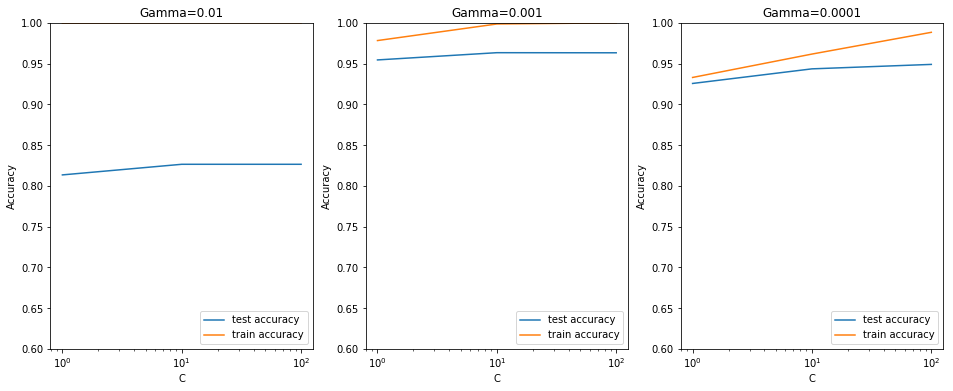

In [66]:
# converting C to numeric type for plotting on x-axis
gs_cv_results['param_C'] = gs_cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(1,3,1)
gamma_01 = gs_cv_results[gs_cv_results['param_gamma'] == 0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

# subplot 2/3
plt.subplot(1,3,2)
gamma_001 = gs_cv_results[gs_cv_results['param_gamma'] == 0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


# subplot 3/3
plt.subplot(1,3,3)
gamma_0001 = gs_cv_results[gs_cv_results['param_gamma'] == 0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

plt.show()

From the plot above, we observe -
- At very high gamma (0.01), the model is achieving 100% accuracy on the training data, though the test score is quite low (<75%). Thus, the model is overfitting.

- At gamma=0.001, the training and test scores are comparable at around C=1, though the model starts to overfit at higher values of C

- At gamma=0.0001, the model does not overfit till C=10 but starts showing signs at C=100. Also, the training and test scores are slightly lower than at gamma=0.001.

Thus, it seems that the best combination is gamma=0.001 and C=1 (the plot in the middle), which gives the highest test accuracy while avoiding overfitting.

So based on GridSearchCV, our best choice of hyperparameters would be - 
- best_C = 1
- best_gamma = 0.001

# Polynomial Kernel

In [118]:
svm_poly = svm.SVC(kernel='poly', C=100, gamma='auto', degree=3, coef0=1, decision_function_shape='ovo')

svm_poly.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [120]:
poly_predictions = svm_poly.predict(X_test)
poly_predictions[:10]

array([4, 0, 0, 8, 1, 1, 6, 0, 2, 6], dtype=int64)

In [121]:
# evaluation: CM 
poly_confusion = metrics.confusion_matrix(y_true = y_test, y_pred = poly_predictions)

# measure accuracy
poly_test_accuracy = metrics.accuracy_score(y_true = y_test, y_pred = poly_predictions)

print("Accuracy - ", poly_test_accuracy, "\n")
print(poly_confusion)

Accuracy -  0.9707142857142858 

[[ 957    0    5    0    5    1    5    0    3    1]
 [   3 1124    4    2    1    0    1    2    2    0]
 [   3    2  950    3    5    1    2    5    1    1]
 [   0    0    4  938    1   11    0    5    9    5]
 [   0    1    7    0  913    1    5    2    2   10]
 [   5    2    1    9    2  813    7    0    5    2]
 [   5    2    3    1    4    3  965    0    3    0]
 [   0    7    7    0    6    0    0  967    1   13]
 [   1    5   12    5    4    4    4    1  956    5]
 [   2    2    2    3   13    3    0   11    1  930]]


### So we built models with LinearSVC, rbf kernel and polynomial kernel. We tuned GridSearchCV with hyperparameters {'C':[1, 10, 100], 'gamma': [1e-2, 1e-3, 1e-4]}.

### From the predictions and accuracy score of all the above models, the model with polynomial kernel turns out to be the best one.


### Hence the model with Polynomial Kernel will be our Final Model

# Part 6 - Final predictions & writing results into the submission file

## Analytics Vidhya

In [91]:
test_data = True
processImages('test_image_pixel_data.csv')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """


In [102]:
processed_test_set_df_AV = pd.read_csv('test_image_pixel_data.csv')

# Rescaling the features
processed_test_set_df_AV = scale(processed_test_set_df_AV)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


In [122]:
# final predict Avalytics Vidhya
final_predictions_AV = svm_poly.predict(processed_test_set_df_AV)
final_predictions_AV[:10]

array([4, 0, 4, 7, 9, 6, 6, 9, 0, 4], dtype=int64)

In [123]:
# Writing prediction results into the submission file

file_names = pd.read_csv('Test_fCbTej3.csv').filename

submission_file_df = pd.DataFrame({'filename': file_names, 'label': final_predictions_AV})

filename = 'submission_AV.csv'

submission_file_df.to_csv(filename, index = False, sep = ",")

### Analytics Vidya solution checker score - 0.9754761905

## Kaggle

In [ ]:
test_data = True
processImages('test_kaggle.csv')

In [ ]:
processed_test_set_df_kaggle = pd.read_csv('test_kaggle.csv')

# Rescaling the features
processed_test_set_df_kaggle = scale(processed_test_set_df_kaggle)

In [124]:
# final predict Kaggle
final_predictions_kaggle = svm_poly.predict(processed_test_set_df_kaggle)
final_predictions_kaggle[:10]

array([2, 0, 9, 4, 3, 7, 0, 3, 0, 3], dtype=int64)

In [125]:
image_ids = []
for i in range(1, 28001):
    image_ids.append(i)

submission_file_df = pd.DataFrame({'ImageId': image_ids, 'Label': final_predictions_kaggle})

filename = 'submission_Kaggle.csv'

submission_file_df.to_csv(filename, index = False, sep = ",")

### Kaggle solution checker score - 0.98714